In [ ]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.insert(0,"/content/gdrive/My Drive/Colab Notebooks/python_package/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from sklearn.manifold import TSNE

In [ ]:
from IPython.display import HTML, display, Javascript
from torch_geometric.datasets import TUDataset
import numpy as np
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import scipy.sparse as sp

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device='cpu'
print(f'Loaded device: {device}')

Loaded device: cuda


# Data Preparation

In [ ]:
# We will use the Mutagenicity dataset, which is part of the standard datasets in torch geometric.
# downloading may take some time
dataset = TUDataset(root='data/mutagen', name='Mutagenicity', use_node_attr=True, use_edge_attr=False)

In [ ]:
# the below list and dict maps an integer to the corresponiding element string and an element string to a color respectively.
# this will be useful for plotting molecules later on

element_map = ['C', 'O', 'Cl', 'H', 'N', 'F', 'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
element_color = {
 'H': [1.0, 1.0, 1.0],
 'Li': [0.8, 0.5019607843137255, 1.0],
 'C': [0.5647058823529412, 0.5647058823529412, 0.5647058823529412],
 'N': [0.18823529411764706, 0.3137254901960784, 0.9725490196078431],
 'O': [1.0, 0.050980392156862744, 0.050980392156862744],
 'F': [0.5647058823529412, 0.8784313725490196, 0.3137254901960784],
 'Na': [0.6705882352941176, 0.3607843137254902, 0.9490196078431372],
 'P': [1.0, 0.5019607843137255, 0.0],
 'S': [1.0, 1.0, 0.18823529411764706],
 'Cl': [0.12156862745098039, 0.9411764705882353, 0.12156862745098039],
 'K': [0.5607843137254902, 0.25098039215686274, 0.8313725490196079],
 'Ca': [0.23921568627450981, 1.0, 0.0],
'Br': [0.6509803921568628, 0.1607843137254902, 0.1607843137254902],
 'I': [0.5803921568627451, 0.0, 0.5803921568627451]}

In [ ]:
print(f'Number of examples: {len(dataset)}')
print('')
print("Let's print a few examples' shape:")
for i in range(4):
    print(dataset[i])

Number of examples: 4337

Let's print a few examples' shape:
Data(edge_index=[2, 32], x=[16, 14], edge_attr=[32, 3], y=[1])
Data(edge_index=[2, 154], x=[72, 14], edge_attr=[154, 3], y=[1])
Data(edge_index=[2, 26], x=[14, 14], edge_attr=[26, 3], y=[1])
Data(edge_index=[2, 76], x=[36, 14], edge_attr=[76, 3], y=[1])


In [ ]:
def draw_molecule(graph, title=''):
    plt.figure(figsize=(10, 5))
    nodes = {}  # create a node dict (idx:element) to create a nx graph
    for i in range(graph.x.shape[0]):
        element_idx = np.argmax(graph.x[i])
        nodes[i] = element_map[element_idx]
    edges = []  # create an edge list for the nx graph
    for i in range(graph.edge_index.shape[1]):
        s, t = graph.edge_index[:, [i]]
        s, t = int(s), int(t)
        edges.append((s, t))

    g = nx.Graph()  # create a graph
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)

    pos = nx.planar_layout(g)  # the graph has no 'position': generate a node-layout
    pos = nx.spring_layout(g, pos=pos)

    colors = [element_color[i] for _, i in nodes.items()]  # set the color for each node
    nx.draw(g, pos=pos, labels=nodes, node_color=colors, width=1)  # and draw the graph

    ax = plt.gca()
    ax.collections[0].set_edgecolor("#000000")  # color the edges

    display(HTML("""<style>#output-body {display: flex;align-items: center;justify-content: center;}</style>"""))  # center the image

    plt.title(title)
    plt.show()

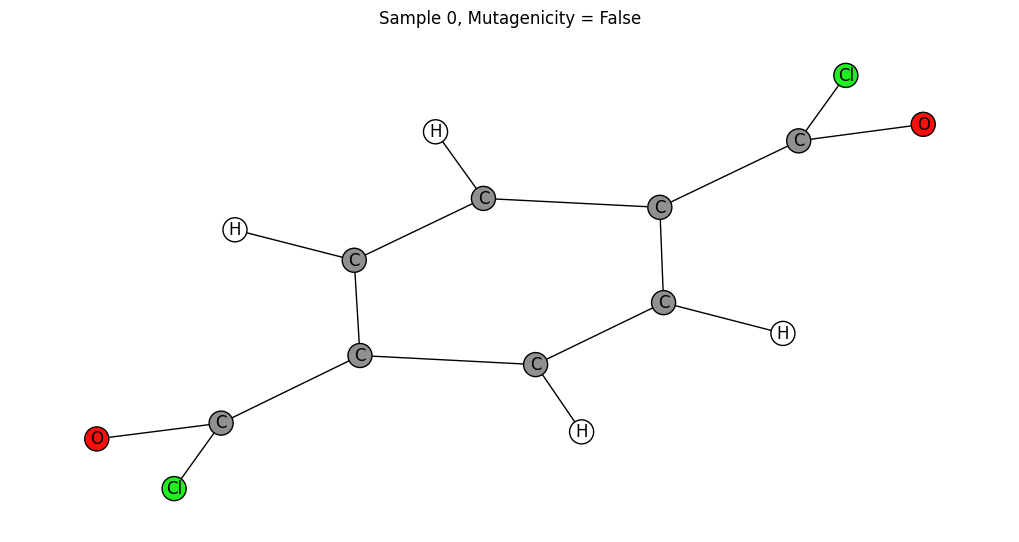

In [ ]:
idx = 0
draw_molecule(dataset[idx], f'Sample {idx}, Mutagenicity = {bool(dataset[idx].y)}')

In [ ]:
'''
We simply shuffle and split the dataset to create a train and validation set.
'''
#dataset.shuffle() # first, shuffle our dataset
train_idx = round(len(dataset) * 0.8) # 80:20 for the train:validation split
dataset_train = dataset[:train_idx]
dataset_val = dataset[train_idx:]

In [ ]:
'''
To process the dataset in minibatches, we use a DataLoader object. All we must do
is supply the data and set the batch_size, PyTorch Geometric will take care of the rest.
Note that the batch_size indicates the number of graphs in a batch, not the number of nodes.
'''
from torch_geometric.loader import DataLoader

batch_size = 256
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [ ]:
# To understand how graphs are batched, print one

for data in train_loader:
    input_feature = data.x
    input_edge_index = data.edge_index

    break

In [ ]:
num_features = int(dataset_train[0].x.shape[1])
num_classes = int(max([d.y for d in dataset_train])+1)

In [ ]:
len(dataset_train)

3470

In [ ]:
3470%124, 3470%128

(122, 14)

# Model


In [ ]:
class Node_to_emb(nn.Module):  # transforms input nodes to an embedding (similar to word embedding in NLP)
    #### why would an embedding layer be useful?

    def __init__(self, node_feat_dim=14, node_emb_dim=64):
        super().__init__()
        self.emb_dim = node_emb_dim
        self.node_dim = node_feat_dim
        self.emb = nn.Linear(self.node_dim, self.emb_dim)


    def forward(self, nodes):
        assert nodes.size(-1) == self.node_dim, 'wrong input dimension of node features!'
        out = self.emb(nodes)
        return out

class MpLayer(torch.nn.Module):  # a neural message passing layer
    def __init__(self, hidden_dim, activation=nn.ReLU()):
        super(MpLayer, self).__init__()

        self.edge_network = nn.Sequential(nn.Linear(2*hidden_dim, hidden_dim),
                                          activation,
                                          nn.Linear(hidden_dim, hidden_dim),
                                          activation
                                          )

        self.node_network = nn.Sequential(nn.Linear(2*hidden_dim, hidden_dim),
                                          activation,
                                          nn.Linear(hidden_dim, hidden_dim),
                                          )

    def forward(self, input_to_layer):
        node_tensor, edge_idx_tensor = input_to_layer
        edge_messages_input = torch.concat([node_tensor[edge_idx_tensor[0,:]], node_tensor[edge_idx_tensor[1,:]]], dim=-1) # shape (num_edges, 2*node_dim + edge_dim)
        edge_messages_output = self.edge_network(edge_messages_input) # shape (num_edges, hidden_dim)

        #now aggregate the edge messages for each node the edge points to:

        node_agg_messages = torch.zeros(node_tensor.size(0), node_tensor.size(1)).to(node_tensor.device)
        node_agg_messages = node_agg_messages.scatter_add_(
            dim=0, index=edge_idx_tensor[1].unsqueeze(-1).expand(-1, node_tensor.size(1)), src=edge_messages_output
        )


        #put the aggregated messages through the node update network:
        node_out = self.node_network(torch.cat([node_tensor, node_agg_messages], dim=-1))

        return node_out, edge_idx_tensor

class MpGNN(torch.nn.Module): # a message passing GNN
    def __init__(self, node_feat_dim, hidden_dim, activation=nn.ReLU(), num_classes=2):
        super(MpGNN, self).__init__()

        #  Hint: the MpGNN must embed the categorical node features, apply message passing layers,
        #        and finally predict the mutagenicity of each graph in the batch.

        self.embedding = Node_to_emb(node_feat_dim, hidden_dim)
        self.mp1 = MpLayer(hidden_dim, activation)
        self.mp2 = MpLayer(hidden_dim, activation)

        self.fc = nn.Linear(hidden_dim, num_classes)



    def forward(self, x, edge_index, batch):
        x = self.embedding(x)

        input_model = (x, edge_index)
        output_model = self.mp1(input_model)
        output_model = self.mp2(output_model)
        x, edge_index = output_model

        out = torch.zeros(max(batch)+1, x.size(1)).to(x.device)
        idx_aggregate_graph = batch.unsqueeze(-1).expand(-1, x.size(1))

        out.scatter_add_(dim=0, index=idx_aggregate_graph, src=x) # aggregate all node embeddings per graph in the batch

        x = self.fc(out)
        return x

class Layer_MpGNN(torch.nn.Module): # a message passing GNN
    def __init__(self, node_feat_dim, hidden_dim, activation=nn.ReLU(), num_classes=2):
        super(Layer_MpGNN, self).__init__()

        #  Hint: the MpGNN must embed the categorical node features, apply message passing layers,
        #        and finally predict the mutagenicity of each graph in the batch.

        self.embedding = Node_to_emb(node_feat_dim, hidden_dim)
        self.mp1 = MpLayer(hidden_dim, activation)
        self.mp2 = MpLayer(hidden_dim, activation)

        self.fc = nn.Linear(hidden_dim, num_classes)


    def forward(self, x, edge_index, batch=None, training_layer='fc'):
        if training_layer == 'embedding':
            emb = self.embedding(x)
            return emb

        elif training_layer == 'mp1':
            emb = self.embedding(x)
            input_model = (emb, edge_index)
            x = self.mp1(input_model)
            return x[0], x[1], emb
        elif training_layer == 'mp2':
            emb = self.embedding(x)
            input_model = (emb, edge_index)
            output_model = self.mp1(input_model)
            x, edge_index = self.mp2(output_model)

            out = torch.zeros(max(batch)+1, x.size(1)).to(x.device)
            idx_aggregate_graph = batch.unsqueeze(-1).expand(-1, x.size(1))

            x = out.scatter_add_(dim=0, index=idx_aggregate_graph, src=x) # aggregate all node embeddings per graph in the batch
            #print(x, x.shape)
            return x
        elif training_layer == 'fc':
            x = self.embedding(x)

            input_model = (x, edge_index)
            output_model = self.mp1(input_model)
            output_model = self.mp2(output_model)
            x, edge_index = output_model

            out = torch.zeros(max(batch)+1, x.size(1)).to(x.device)
            idx_aggregate_graph = batch.unsqueeze(-1).expand(-1, x.size(1))

            x = out.scatter_add_(dim=0, index=idx_aggregate_graph, src=x) # aggregate all node embeddings per graph in the batch


            x = self.fc(x)
            return x

# Evaluation

In [ ]:
def plot_loss(layer1, epoche, loss_type):
    """
    plot the loss change during the training precedure
    """
    plt.title("Train "+ loss_type)
    plt.xlabel("epoch")
    plt.ylabel(loss_type)
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, layer1)
    #plt.plot(epoche_range, layer2)
    #plt.plot(epoche_range, fc)
    plt.legend([loss_type], loc='best')
    plt.show()

def plot_acc(train, test, epoche):
    """
    plot the loss change during the training precedure
    """
    plt.title("Train and validation Accuarcy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, train)
    plt.plot(epoche_range, test)
    #plt.plot(epoche_range, fc)
    plt.legend(['train accuracy', 'test accuracy'], loc='best')
    plt.show()

def eval(model, train_loader = train_loader, isprint=True):
    model.eval()  # set the model to evaluation mode (no dropout)

    correct = 0  # keep track of how many we have correct
    total = 0  # and how many we handle in total
    for data in train_loader:  # loop through the supplied dataset in a batch-wise fashion
        data.to(device)  # transfer batch to device
        out = model(data.x, data.edge_index, data.batch)  # propagate the data through the model
        pred = out.argmax(dim=1)  # as prediction, we take the class with the highest probability
        correct += int((pred == data.y).sum())  # add the number of correct predictions
        total += len(data.y)  # and add the total number of elements
    train_acc = correct / total  # return the accuracy

    correct = 0  # keep track of how many we have correct
    total = 0  # and how many we handle in total
    for data in val_loader:  # loop through the supplied dataset in a batch-wise fashion
        data.to(device)  # transfer batch to device
        out = model(data.x, data.edge_index, data.batch)  # propagate the data through the model
        pred = out.argmax(dim=1)  # as prediction, we take the class with the highest probability
        correct += int((pred == data.y).sum())  # add the number of correct predictions
        total += len(data.y)  # and add the total number of elements
    val_acc = correct / total  # return the accuracy

    if isprint:
        print('Accuracy of the network on the train: {} %'.format(100 * train_acc))
        print('Accuracy of the network on the test: {} %'.format(100 * val_acc))

    return train_acc, val_acc

# MINE

In [ ]:
import math

torch.autograd.set_detect_anomaly(True)

EPS = 1e-6

class EMALoss(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, running_ema):
        ctx.save_for_backward(input, running_ema)
        input_log_sum_exp = input.exp().mean().log()

        return input_log_sum_exp

    @staticmethod
    def backward(ctx, grad_output):
        input, running_mean = ctx.saved_tensors
        grad = grad_output * input.exp().detach() / \
            (running_mean + EPS) / input.shape[0]
        return grad, None


def ema(mu, alpha, past_ema):
    return alpha * mu + (1.0 - alpha) * past_ema


def ema_loss(x, running_mean, alpha):
    t_exp = torch.exp(torch.logsumexp(x, 0) - math.log(x.shape[0])).detach()
    if running_mean == 0:
        running_mean = t_exp
    else:
        running_mean = ema(t_exp, alpha, running_mean.item())
    t_log = EMALoss.apply(x, running_mean)

    # Recalculate ema

    return t_log, running_mean

class ConcatLayer(nn.Module):
    def __init__(self, dim=1):
        super().__init__()
        self.dim = dim

    def forward(self, x, y):
        x = x.view(x.shape[0], -1)
        y = y.view(y.shape[0], -1)
        return torch.cat((x, y), self.dim)


class CustomSequential(nn.Sequential):
    def forward(self, *input):
        for module in self._modules.values():
            if isinstance(input, tuple):
                input = module(*input)
            else:
                input = module(input)
        return input

class T(nn.Module):
    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.layers = CustomSequential(ConcatLayer(), nn.Linear(x_dim + z_dim, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 1))


    def forward(self, x, z):
        return self.layers(x, z)

class Mine(nn.Module):
    def __init__(self, T, loss='mine', alpha=0.01, method=None):
        super().__init__()
        self.running_mean = 0
        self.loss = loss
        self.alpha = alpha
        self.method = method

        if method == 'concat':
            if isinstance(T, nn.Sequential):
                self.T = CustomSequential(ConcatLayer(), *T)
            else:
                self.T = CustomSequential(ConcatLayer(), T)
        else:
            self.T = T

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])]

        t = self.T(x, z).mean()
        t_marg = self.T(x, z_marg)

        if self.loss in ['mine']:
            second_term, self.running_mean = ema_loss(
                t_marg, self.running_mean, self.alpha)
        elif self.loss in ['fdiv']:
            second_term = torch.exp(t_marg - 1).mean()
        elif self.loss in ['mine_biased']:
            second_term = torch.logsumexp(
                t_marg, 0) - math.log(t_marg.shape[0])

        return -t + second_term

# GMI

In [ ]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

def negative_sampling(adj_ori, sample_times, emb_dim):
    sample_list = []
    for j in range(sample_times):
        sample_iter = []
        i = 0
        while True:
            #randnum = np.random.randint(0,adj_ori.shape[0])
            randnum = np.random.randint(0, emb_dim)
            if randnum!=i:
                sample_iter.append(randnum)
                i = i+1
            #if len(sample_iter)==adj_ori.shape[0]:
            if len(sample_iter)==emb_dim:
                break
        sample_list.append(sample_iter)
    return sample_list

def sp_func(arg):
    return torch.log(1+torch.exp(arg))

def mi_loss_jsd(pos, neg):
    e_pos = torch.mean(sp_func(-pos))
    e_neg = torch.mean(torch.mean(sp_func(neg),0))
    return e_pos+e_neg

def reconstruct_loss(pre, gnd):
    nodes_n = gnd.shape[0]
    edges_n = np.sum(gnd)/2
    weight1 = (nodes_n*nodes_n-edges_n)*1.0/edges_n
    weight2 = nodes_n*nodes_n*1.0/(nodes_n*nodes_n-edges_n)
    gnd = torch.FloatTensor(gnd).to(device)
    temp1 = gnd*torch.log(pre+(1e-10))*(-weight1)
    temp2 = (1-gnd)*torch.log(1-pre+(1e-10))
    return torch.mean(temp1-temp2)*weight2

def to_adj_matrix(feature_matrix, edge_index):
    dimension = feature_matrix.size(0)
    adj_matrix = torch.zeros(dimension, dimension)
    for edge in edge_index.t():
        x = int(edge[0].item())
        y = int(edge[1].item())
        adj_matrix[x][y] = 1
        adj_matrix[y][x] = 1

    return adj_matrix.numpy()

def edge_index_to_list_tuple(edge_index):
    list_list = torch.transpose(edge_index, 0, 1)
    list_tuple = []
    for item in list_list:
        list_tuple.append((item[0], item[1]))
    return list_tuple

def Vertex_List(features):
    num = features.shape[0]
    return [*range(num)]

def EdgeListtoAdjMat(V,E):
    GA={}
    conneclist=[]
    for i in range(len(V)):
        for j in range(len(V)):
            # Checking if a pair of two different elements exists in either format inside E.
            if not i==j and ((V[i],V[j]) in E or (V[j],V[i]) in E):
                conneclist.append(V[j])
        GA[V[i]]=conneclist
        conneclist = []
    return(GA)

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_ft, out_ft, act, bias=True):
        super(GCN, self).__init__()
        self.fc = nn.Linear(in_ft, out_ft, bias=False)
        self.act = nn.PReLU() if act == 'prelu' else act

        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_ft))
            self.bias.data.fill_(0.0)
        else:
            self.register_parameter('bias', None)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, seq, adj):
        seq_fts = self.fc(seq)
        out = torch.unsqueeze(torch.spmm(adj, torch.squeeze(seq_fts, 0)), 0)

        if self.bias is not None:
            out += self.bias

        return self.act(out), seq_fts

class Discriminator(nn.Module):
    def __init__(self, n_h1, n_h2):
        super(Discriminator, self).__init__()
        self.f_k = nn.Bilinear(n_h1, n_h2, 1)
        self.act = nn.Sigmoid()

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, h_c, h_pl, sample_list, s_bias1=None, s_bias2=None):

        if len(h_c.shape) == 3:
            h_c = torch.squeeze(h_c, 0)
        sc_1 = self.f_k(h_pl, h_c)

        #if len(sc_1.shape) == 3:
            #sc_1 = torch.squeeze(sc_1, 2)
        sc_1 = self.act(sc_1)
        sc_2_list = []
        for i in range(len(sample_list)):

            h_mi = h_pl[0][sample_list[i]]
            h_mi = torch.unsqueeze(h_mi, 0).expand_as(h_c)
            sc_2_iter = self.f_k(h_mi, h_c)
            sc_2_iter = self.f_k(h_mi, h_c)
            if len(sc_2_iter) == 3:
              sc_2_iter = torch.squeeze(sc_2_iter, 1)
            sc_2_list.append(sc_2_iter)
            #h_mi = torch.unsqueeze(h_pl[0][sample_list[i]],0).expand_as(h_c)
            #print(h_pl[0][sample_list[i]].shape, h_mi.shape)
            #sc_2_iter = torch.squeeze(self.f_k(h_mi, h_c), 2)
            #sc_2_list.append(sc_2_iter)

        sc_2_stack = torch.squeeze(torch.stack(sc_2_list,1),0)
        sc_2 = self.act(sc_2_stack)

        if s_bias1 is not None:
            sc_1 += s_bias1
        if s_bias2 is not None:
            sc_2 += s_bias2

        return sc_1, sc_2

# Applies mean-pooling on neighbors
class AvgNeighbor(nn.Module):
    def __init__(self):
        super(AvgNeighbor, self).__init__()

    def forward(self, seq, adj_ori):
        adj_ori = sparse_mx_to_torch_sparse_tensor(adj_ori)
        if torch.cuda.is_available():
            adj_ori = adj_ori.cuda()
        return torch.unsqueeze(torch.spmm(adj_ori, torch.squeeze(seq, 0)), 0)

In [ ]:
class GMI(nn.Module):
    def __init__(self, n_in, n_h, activation):
        super(GMI, self).__init__()
        #self.gcn1 = GCN(n_in, n_h, activation)  # if on citeseer and pubmed, the encoder is 1-layer GCN, you need to modify it
        #self.gcn2 = GCN(n_h, n_h, activation)
        self.disc1 = Discriminator(n_in, n_h)
        self.disc2 = Discriminator(n_h, n_h)
        self.avg_neighbor = AvgNeighbor()
        self.prelu = nn.PReLU()
        self.sigm = nn.Sigmoid()

    def forward(self, input_feature, output_feature, adj_ori, neg_num, adj, adj_target, samp_bias1, samp_bias2, alpha=0.8, beta=1.0, gamma=1.0):
        #h_1, h_w = self.gcn1(seq1, adj)
        #h_2, _ = self.gcn2(h_1, adj)
        #h_neighbor = self.prelu(self.avg_neighbor(h_w, adj_ori))
        h_neighbor = self.prelu(self.avg_neighbor(input_feature, adj_ori))

        """FMI (X_i consists of the node i itself and its neighbors)"""
        # I(h_i; x_i)
        #res_mi_pos, res_mi_neg = self.disc1(h_2, seq1, negative_sampling(adj_ori, neg_num), samp_bias1, samp_bias2)
        res_mi_pos, res_mi_neg = self.disc1(output_feature, input_feature, negative_sampling(adj_ori, neg_num, input_feature.shape[1]), samp_bias1, samp_bias2)
        # I(h_i; x_j) node j is a neighbor
        res_local_pos, res_local_neg = self.disc2(h_neighbor, output_feature, negative_sampling(adj_ori, neg_num, input_feature.shape[1]), samp_bias1, samp_bias2)
        """I(w_ij; a_ij)"""
        adj_rebuilt = self.sigm(torch.mm(torch.squeeze(output_feature), torch.t(torch.squeeze(output_feature))))
        res = (res_mi_pos, res_mi_neg, res_local_pos, res_local_neg, adj_rebuilt)
        #loss = args.alpha*process.mi_loss_jsd(res[0], res[1]) + args.beta*process.mi_loss_jsd(res[2], res[3]) + args.gamma*process.reconstruct_loss(res[4], adj_target)
        #return res_mi_pos, res_mi_neg, res_local_pos, res_local_neg, adj_rebuilt
        return alpha*mi_loss_jsd(res[0], res[1]) + beta*mi_loss_jsd(res[2], res[3]) + gamma*reconstruct_loss(res[4], adj_target)

    # detach the return variables
    def embed(self, seq, adj):
        h_1, _ = self.gcn1(seq, adj)
        h_2, _ = self.gcn2(h_1, adj)

        return h_2.detach()

# Train

In [ ]:
def training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader, iseval = False):
  result_list = []
  total_step = len(train_loader)
  train_acc_list = []
  test_acc_list = []
  best = 1e9
  #if loss_type != "cross entropy":
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
  for epoch in range(num_epochs):

    #print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
    model.train()
    if loss_type != "cross entropy":
      mine.train()
    sum_MI = 0
    for data in train_loader:  # loop through the training set in a batch-wise fashion
      data.to(device)  # move the batch to the device (GPU if applicable)
      input_feature = data.x
      input_edge_index = data.edge_index
      y_expanded = torch.zeros(data.y.size(0), 2).to(device)
      y_expanded[:, 0] += data.y == 0
      y_expanded[:, 1] += data.y == 1

      # Forward pass
      outputs  = model(data.x, data.edge_index, data.batch, training_layer = training_layer)

      if loss_type == '-MI(X;Z)':

        output_feature = outputs[0]
        output_edge_index = outputs[1]
        emb = outputs[2]

        adj_ori = to_adj_matrix(input_feature, input_edge_index)  # dense matrix
        adj_ori = sp.csr_matrix(adj_ori)  # sparse matrix
        adj = normalize_adj(adj_ori + sp.eye(adj_ori.shape[0]))
        sp_adj = sparse_mx_to_torch_sparse_tensor(adj).to(device)

        adj_dense = adj_ori.toarray()
        #adj_dense = adj_ori
        adj_target = adj_dense+np.eye(adj_dense.shape[0])
        np.seterr(invalid='ignore')
        adj_row_avg = 1.0/np.sum(adj_dense, axis=1)
        adj_row_avg[np.isnan(adj_row_avg)] = 0.0
        adj_row_avg[np.isinf(adj_row_avg)] = 0.0
        adj_dense = adj_dense*1.0
        for i in range(adj_ori.shape[0]):
          adj_dense[i] = adj_dense[i]*adj_row_avg[i]
        adj_ori = sp.csr_matrix(adj_dense, dtype=np.float32)
        loss = mine(input_feature=emb, output_feature=output_feature, adj_ori=adj_ori, neg_num=5, adj=sp_adj, adj_target=adj_target, samp_bias1=None, samp_bias2=None)

        if loss.item() < best:
          best = loss.item()
          model_save_name = 'GGMI.pt'
          path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
          torch.save(model, path)
          model_save_name = 'GGMIlayer2.pt'
          path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
          torch.save(mine, path)

      elif loss_type == '-MI(X;Z) embedding':
        output_feature = outputs
        loss = mine(input_feature, output_feature).to(device)

        if loss.item() < best:
          best = loss.item()
          model_save_name = 'GGMI.pt'
          path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
          torch.save(model, path)
          model_save_name = 'GGMIlayer1.pt'
          path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
          torch.save(mine, path)

      elif loss_type == '-MI(Y;Z)':
        loss = mine(y_expanded, outputs).to(device)

        if loss.item() < best:
          best = loss.item()
          model_save_name = 'GGMI.pt'
          path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
          torch.save(model, path)
          model_save_name = 'GGMIlayer3.pt'
          path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
          torch.save(mine, path)

      elif loss_type == "cross entropy":
        loss = mine(outputs, y_expanded).to(device)
        if loss.item() < best:
          best = loss.item()
          model_save_name = 'GGMI.pt'
          path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
          torch.save(model, path)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #if loss_type != "cross entropy":
        #scheduler.step()
      MI = loss.item()
      sum_MI += MI

    avg_MI = sum_MI/total_step
    result_list.append(avg_MI)
    output = 'Epoch [{}/{}], '+ training_layer+' ' + loss_type +' : {:.12f}'
    print (output.format(epoch+1, num_epochs, avg_MI))
    if iseval:
      if epoch == num_epochs-1:
        isprint = True
      else:
        isprint = False
      train_acc, test_acc = eval(model, isprint=isprint)
      train_acc_list.append(train_acc)
      test_acc_list.append(test_acc)
  if len(train_acc_list) == num_epochs:
    plot_acc(train_acc_list, test_acc_list, num_epochs)

  if iseval:
    return result_list, train_acc_list[-1], test_acc_list[-1]
  else:
    return result_list

# Modular Training

In [ ]:
def Modular_training(model, num_epochs, estimator, loss_list, layer_list, train_dataset):
    if len(train_dataset) < 2:
        train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
    else:
        train_loader = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True)
    model.train()
    for param in model.parameters():
        param.requires_grad = False

    #training embedding
    print("Training embedding")
    for name, param in model.embedding.named_parameters():
        param.requires_grad = True
    #mine = estimator[0].to(device)
    mine = estimator[0].to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-5},
                                {"params": mine.parameters(), "lr": 1e-6}])
    loss_type = loss_list[0]
    training_layer = layer_list[0]
    emb = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.embedding.named_parameters():
        param.requires_grad = False

    #training mp1
    print("Training mp1")
    for name, param in model.mp1.named_parameters():
        param.requires_grad = True
    #mine = estimator[1].to(device)
    mine = estimator[1].to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-5},
                                {"params": mine.parameters(), "lr": 1e-6}])
    loss_type = loss_list[1]
    training_layer = layer_list[1]
    mp1 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.mp1.named_parameters():
        param.requires_grad = False

    #training mp2
    print("Training mp2")
    for name, param in model.mp2.named_parameters():
        param.requires_grad = True
    mine = Mine(estimator[2]).to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-4},
                                {"params": mine.parameters(), "lr": 1e-4}])
    loss_type = loss_list[2]
    training_layer = layer_list[2]
    mp2 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.mp2.named_parameters():
        param.requires_grad = False

    #training fc
    print("Training fc")
    train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
    for name, param in model.fc.named_parameters():
        param.requires_grad = True
    mine = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_type = loss_list[3]
    training_layer = layer_list[3]
    fc, train_acc, test_acc = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader, iseval=True)
    for name, param in model.fc.named_parameters():
        param.requires_grad = False

    return emb, mp1, mp2, fc, train_acc, test_acc
  #return mp1, mp2, fc, train_acc, test_acc

# Model and Estimators Initialization

In [ ]:
model = Layer_MpGNN(14,32).to(device)
T_estimator = [Mine(T(14, 32)),
               GMI(32, 32, 'prelu'),
               Mine(T(2, 32))]

In [ ]:
# save model
model_save_name = 'GGMI.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
torch.save(model, path)
model_save_name = 'GGMIlayer1.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
torch.save(T_estimator[0], path)
model_save_name = 'GGMIlayer2.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
torch.save(T_estimator[1], path)
model_save_name = 'GGMIlayer3.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
torch.save(T_estimator[2], path)
train_acc, test_acc = eval(model, isprint=True)

Accuracy of the network on the train: 44.351585014409224 %
Accuracy of the network on the test: 45.79008073817762 %


# Training Embedding

In [ ]:
model_save_name = 'GGMI.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
model = torch.load(path)
model_save_name = 'GGMIlayer1.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator1 = torch.load(path)
model_save_name = 'GGMIlayer2.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator2 = torch.load(path)
model_save_name = 'GGMIlayer3.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator3 = torch.load(path)
T_estimator = [T_estimator1, T_estimator2, T_estimator3]
train_acc, test_acc = eval(model, isprint=True)

Accuracy of the network on the train: 44.351585014409224 %
Accuracy of the network on the test: 45.79008073817762 %


Training embedding
Epoch [1/100], embedding -MI(X;Z) embedding : -1.114852774899
Epoch [2/100], embedding -MI(X;Z) embedding : -1.104898486117
Epoch [3/100], embedding -MI(X;Z) embedding : -1.111826724037
Epoch [4/100], embedding -MI(X;Z) embedding : -1.103629499313
Epoch [5/100], embedding -MI(X;Z) embedding : -1.111948925274
Epoch [6/100], embedding -MI(X;Z) embedding : -1.112521789053
Epoch [7/100], embedding -MI(X;Z) embedding : -1.092818329073
Epoch [8/100], embedding -MI(X;Z) embedding : -1.111733237570
Epoch [9/100], embedding -MI(X;Z) embedding : -1.092806467302
Epoch [10/100], embedding -MI(X;Z) embedding : -1.105511257250
Epoch [11/100], embedding -MI(X;Z) embedding : -1.106122537065
Epoch [12/100], embedding -MI(X;Z) embedding : -1.116670795408
Epoch [13/100], embedding -MI(X;Z) embedding : -1.116367984746
Epoch [14/100], embedding -MI(X;Z) embedding : -1.113543503257
Epoch [15/100], embedding -MI(X;Z) embedding : -1.100694198945
Epoch [16/100], embedding -MI(X;Z) embedding 

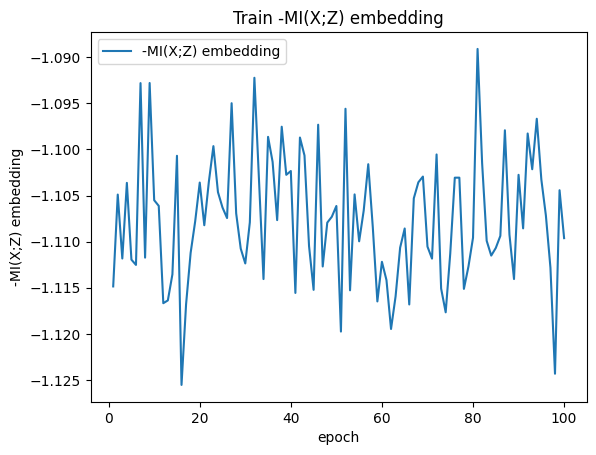

In [ ]:
loss_list = ['-MI(X;Z) embedding', '-MI(X;Z)', "-MI(Y;Z)", "cross entropy"]
layer_list = ['embedding','mp1', 'mp2', 'fc']
num_epochs = 200

if len(dataset_train) < 124:
    train_loader = DataLoader(dataset=dataset_train, batch_size=len(dataset_train), shuffle=True)
else:
    train_loader = DataLoader(dataset=dataset_train, batch_size=2, shuffle=True)

for param in model.parameters():
    param.requires_grad = False

#training embedding
print("Training embedding")
for name, param in model.embedding.named_parameters():
    param.requires_grad = True

mine = T_estimator[0].to(device)
optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-5},
                                {"params": mine.parameters(), "lr": 1e-5}])
loss_type = loss_list[0]
training_layer = layer_list[0]
emb = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
for name, param in model.embedding.named_parameters():
    param.requires_grad = False

plot_loss(emb, num_epochs, loss_list[0])

# Training MP1

In [ ]:
model_save_name = 'GGMI.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
model = torch.load(path)
model_save_name = 'GGMIlayer1.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator1 = torch.load(path)
model_save_name = 'GGMIlayer2.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator2 = torch.load(path)
model_save_name = 'GGMIlayer3.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator3 = torch.load(path)
T_estimator = [T_estimator1, T_estimator2, T_estimator3]
train_acc, test_acc = eval(model, isprint=True)

Accuracy of the network on the train: 53.51585014409221 %
Accuracy of the network on the test: 56.05536332179931 %


Training mp1


<ipython-input-21-b0350cd623e1>:42: RuntimeWarning: divide by zero encountered in true_divide
  adj_row_avg = 1.0/np.sum(adj_dense, axis=1)


Epoch [1/100], mp1 -MI(X;Z) : 3.282269273485
Epoch [2/100], mp1 -MI(X;Z) : 3.247994644301
Epoch [3/100], mp1 -MI(X;Z) : 3.251516384738
Epoch [4/100], mp1 -MI(X;Z) : 3.249974668026
Epoch [5/100], mp1 -MI(X;Z) : 3.263416511672
Epoch [6/100], mp1 -MI(X;Z) : 3.260140444551
Epoch [7/100], mp1 -MI(X;Z) : 3.263363020761
Epoch [8/100], mp1 -MI(X;Z) : 3.265160935266
Epoch [9/100], mp1 -MI(X;Z) : 3.281107068062
Epoch [10/100], mp1 -MI(X;Z) : 3.260379825320
Epoch [11/100], mp1 -MI(X;Z) : 3.248103950705
Epoch [12/100], mp1 -MI(X;Z) : 3.248634219170
Epoch [13/100], mp1 -MI(X;Z) : 3.260767868587
Epoch [14/100], mp1 -MI(X;Z) : 3.257982381753
Epoch [15/100], mp1 -MI(X;Z) : 3.276857129165
Epoch [16/100], mp1 -MI(X;Z) : 3.266389480659
Epoch [17/100], mp1 -MI(X;Z) : 3.242971411773
Epoch [18/100], mp1 -MI(X;Z) : 3.261277735233
Epoch [19/100], mp1 -MI(X;Z) : 3.254358129842
Epoch [20/100], mp1 -MI(X;Z) : 3.269397684506
Epoch [21/100], mp1 -MI(X;Z) : 3.261090840612
Epoch [22/100], mp1 -MI(X;Z) : 3.2607644115

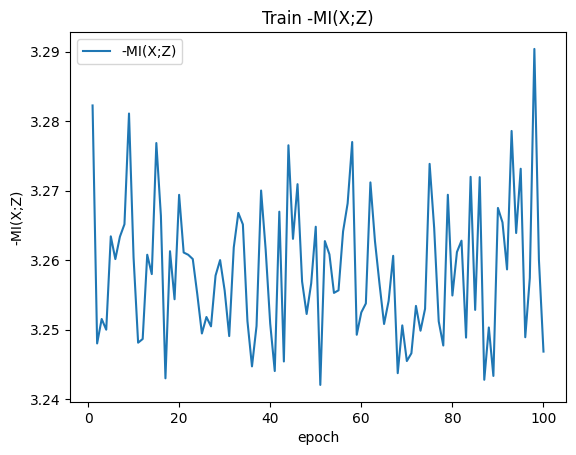

In [ ]:
loss_list = ['-MI(X;Z) embedding', '-MI(X;Z)', "-MI(Y;Z)", "cross entropy"]
layer_list = ['embedding','mp1', 'mp2', 'fc']
num_epochs = 100

if len(dataset_train) < 124:
    train_loader = DataLoader(dataset=dataset_train, batch_size=len(dataset_train), shuffle=True)
else:
    train_loader = DataLoader(dataset=dataset_train, batch_size=124, shuffle=True)

for param in model.parameters():
    param.requires_grad = False


#training mp1
print("Training mp1")
for name, param in model.mp1.named_parameters():
    param.requires_grad = True

mine = T_estimator[1].to(device)
optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-6},
                                {"params": mine.parameters(), "lr": 1e-7}])
loss_type = loss_list[1]
training_layer = layer_list[1]
mp1 = training_block(num_epochs, model.to(device), training_layer, mine, loss_type, optimizer, train_loader)
for name, param in model.mp1.named_parameters():
    param.requires_grad = False
plot_loss(mp1, num_epochs, loss_list[1])

# Training Mp2

In [ ]:
model_save_name = 'GGMI.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
model = torch.load(path)
model_save_name = 'GGMIlayer1.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator1 = torch.load(path)
model_save_name = 'GGMIlayer2.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator2 = torch.load(path)
model_save_name = 'GGMIlayer3.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator3 = torch.load(path)
T_estimator = [T_estimator1, T_estimator2, T_estimator3]
train_acc, test_acc = eval(model, isprint=True)

Accuracy of the network on the train: 59.71181556195966 %
Accuracy of the network on the test: 61.245674740484425 %


Training mp2
Epoch [1/200], mp2 -MI(Y;Z) : -0.358210760568
Epoch [2/200], mp2 -MI(Y;Z) : -0.358667926065
Epoch [3/200], mp2 -MI(Y;Z) : -0.356317380177
Epoch [4/200], mp2 -MI(Y;Z) : -0.353408484587
Epoch [5/200], mp2 -MI(Y;Z) : -0.359768288476
Epoch [6/200], mp2 -MI(Y;Z) : -0.364382600678
Epoch [7/200], mp2 -MI(Y;Z) : -0.361661760403
Epoch [8/200], mp2 -MI(Y;Z) : -0.375038360379
Epoch [9/200], mp2 -MI(Y;Z) : -0.367837475879
Epoch [10/200], mp2 -MI(Y;Z) : -0.384702814477
Epoch [11/200], mp2 -MI(Y;Z) : -0.347691083061
Epoch [12/200], mp2 -MI(Y;Z) : -0.374891539237
Epoch [13/200], mp2 -MI(Y;Z) : -0.382873428187
Epoch [14/200], mp2 -MI(Y;Z) : -0.378879752542
Epoch [15/200], mp2 -MI(Y;Z) : -0.353325522372
Epoch [16/200], mp2 -MI(Y;Z) : -0.372908848205
Epoch [17/200], mp2 -MI(Y;Z) : -0.357919469476
Epoch [18/200], mp2 -MI(Y;Z) : -0.383239504482
Epoch [19/200], mp2 -MI(Y;Z) : -0.376688975309
Epoch [20/200], mp2 -MI(Y;Z) : -0.356304715254
Epoch [21/200], mp2 -MI(Y;Z) : -0.369022962770
Epoch [22

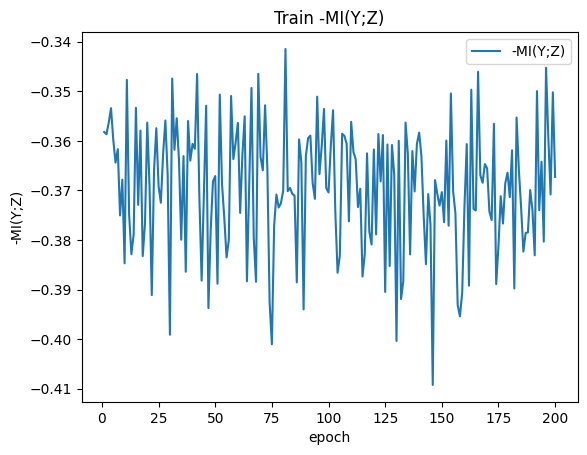

In [ ]:
loss_list = ['-MI(X;Z) embedding', '-MI(X;Z)', "-MI(Y;Z)", "cross entropy"]
layer_list = ['embedding','mp1', 'mp2', 'fc']
num_epochs = 200

if len(dataset_train) < 124:
    train_loader = DataLoader(dataset=dataset_train, batch_size=len(dataset_train), shuffle=True)
else:
    train_loader = DataLoader(dataset=dataset_train, batch_size=124, shuffle=True)

for param in model.parameters():
    param.requires_grad = False

#training mp2
print("Training mp2")
for name, param in model.mp2.named_parameters():
    param.requires_grad = True
mine = T_estimator[2].to(device)
optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-7},
                                {"params": mine.parameters(), "lr": 1e-7}])
loss_type = loss_list[2]
training_layer = layer_list[2]
mp2 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
for name, param in model.mp2.named_parameters():
    param.requires_grad = False
plot_loss(mp2, num_epochs, loss_list[2])

# Training fc

In [ ]:
model_save_name = 'GGMI.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
model = torch.load(path)
model_save_name = 'GGMIlayer1.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator1 = torch.load(path)
model_save_name = 'GGMIlayer2.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator2 = torch.load(path)
model_save_name = 'GGMIlayer3.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator3 = torch.load(path)
T_estimator = [T_estimator1, T_estimator2, T_estimator3]
train_acc, test_acc = eval(model, isprint=True)

Accuracy of the network on the train: 75.56195965417868 %
Accuracy of the network on the test: 76.00922722029988 %


Training fc
Epoch [1/100], fc cross entropy : 0.530032079328
Epoch [2/100], fc cross entropy : 0.525754906373
Epoch [3/100], fc cross entropy : 0.525424700434
Epoch [4/100], fc cross entropy : 0.527472533963
Epoch [5/100], fc cross entropy : 0.524020222642
Epoch [6/100], fc cross entropy : 0.531009208072
Epoch [7/100], fc cross entropy : 0.526729455319
Epoch [8/100], fc cross entropy : 0.526131031730
Epoch [9/100], fc cross entropy : 0.527861286293
Epoch [10/100], fc cross entropy : 0.526723473180
Epoch [11/100], fc cross entropy : 0.525332584164
Epoch [12/100], fc cross entropy : 0.530261262439
Epoch [13/100], fc cross entropy : 0.524612813104
Epoch [14/100], fc cross entropy : 0.528855150396
Epoch [15/100], fc cross entropy : 0.526270302317
Epoch [16/100], fc cross entropy : 0.527223447778
Epoch [17/100], fc cross entropy : 0.530401201140
Epoch [18/100], fc cross entropy : 0.527683331208
Epoch [19/100], fc cross entropy : 0.525589160486
Epoch [20/100], fc cross entropy : 0.5252850873

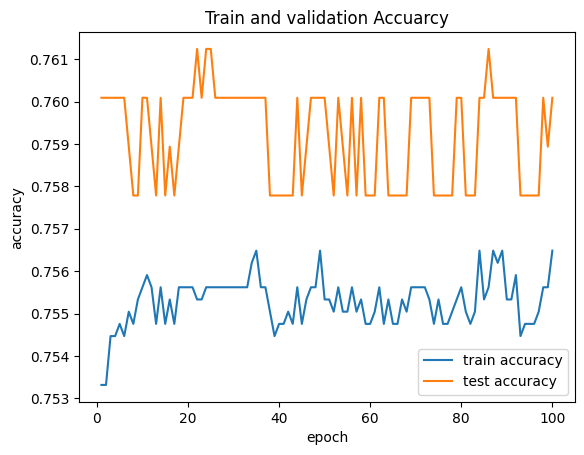

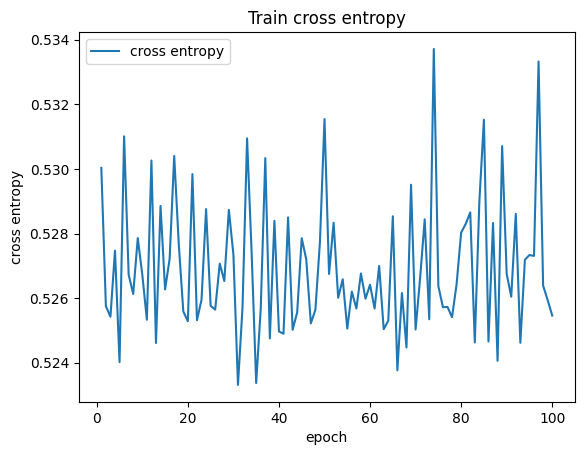

In [ ]:
loss_list = ['-MI(X;Z) embedding', '-MI(X;Z)', "-MI(Y;Z)", "cross entropy"]
layer_list = ['embedding','mp1', 'mp2', 'fc']
num_epochs = 100

for param in model.parameters():
    param.requires_grad = False

#training fc
print("Training fc")
train_loader = DataLoader(dataset=dataset_train, batch_size=64, shuffle=True)
for name, param in model.fc.named_parameters():
    param.requires_grad = True
mine = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_type = loss_list[3]
training_layer = layer_list[3]
fc, train_acc, test_acc = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader, iseval=True)
for name, param in model.fc.named_parameters():
    param.requires_grad = False

plot_loss(fc, num_epochs, loss_list[3])

# Save Model

In [ ]:
# save model
model_save_name = 'GGMI.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
torch.save(model, path)

In [ ]:
# save model
model_save_name = 'GGMI.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
torch.save(model, path)
model_save_name = 'GGMIlayer1.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
torch.save(T_estimator[0], path)
model_save_name = 'GGMIlayer2.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
torch.save(T_estimator[1], path)
model_save_name = 'GGMIlayer3.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
torch.save(T_estimator[2], path)

# Load Model

In [ ]:
# load saved model
model_save_name = 'GGMI.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
model = torch.load(path)

In [ ]:
train_acc, test_acc = eval(model, isprint=True)

Accuracy of the network on the train: 75.56195965417868 %
Accuracy of the network on the test: 76.00922722029988 %


In [ ]:
model

Layer_MpGNN(
  (embedding): Node_to_emb(
    (emb): Linear(in_features=14, out_features=32, bias=True)
  )
  (mp1): MpLayer(
    (edge_network): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
    )
    (node_network): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (mp2): MpLayer(
    (edge_network): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
    )
    (node_network): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

Compute the output of each layer

In [ ]:
loader = DataLoader(dataset_val, batch_size=1, shuffle=False)

In [ ]:
def layer_output(model, train_loader, training_layer):
    model.eval()
    output_list = []
    with torch.no_grad():

        for data in train_loader:
            data.to(device)
            input_feature = data.x
            input_edge_index = data.edge_index
            label = data.y
            outputs = model(data.x, data.edge_index, data.batch, training_layer = training_layer)

            output_list.append([outputs, label])

    return output_list

In [ ]:
embedding_outputs = layer_output(model.to(device), loader, 'embedding')
mp2_outputs = layer_output(model.to(device), loader, 'mp2')
fc_outputs = layer_output(model.to(device), loader, 'fc')

In [ ]:
def mp1_output(model, train_loader, training_layer):
    model.eval()
    output_list = []
    with torch.no_grad():

        for data in train_loader:
            data.to(device)
            input_feature = data.x
            input_edge_index = data.edge_index
            label = data.y
            outputs = model(data.x, data.edge_index, data.batch, training_layer = training_layer)
            output_list.append([outputs[0], label])

    return output_list

In [ ]:
mp1_outputs = mp1_output(model, loader, 'mp1')

Visualize the mp2


In [ ]:
mp2_x = []
mp2_y = []
for item in mp2_outputs:
    x = item[0][0].cpu().numpy()
    y = item[1][0].cpu().numpy()
    mp2_x.append(x)
    mp2_y.append(y)

mp2_x = np.array(mp2_x)
mp2_y = np.array(mp2_y)

In [ ]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd
import numpy as np
from google.colab import files

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(mp2_x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 867 samples in 0.001s...
[t-SNE] Computed neighbors for 867 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 867 / 867
[t-SNE] Mean sigma: 1.371142
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.072834
[t-SNE] KL divergence after 1000 iterations: 0.667940


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

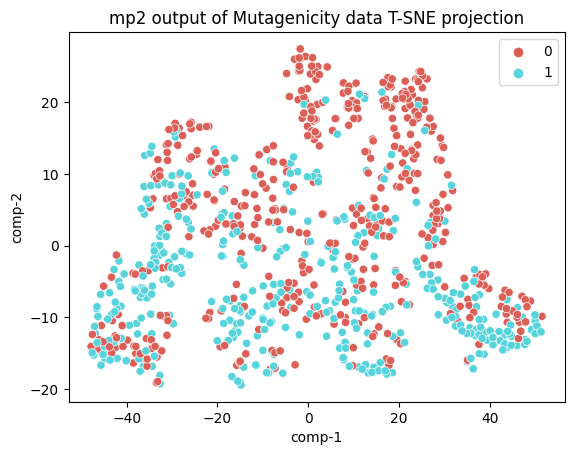

In [ ]:
df = pd.DataFrame()
df["y"] = mp2_y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="mp2 output of Mutagenicity data T-SNE projection")

plt.savefig('GNN_Mutagenicity_mp2_tsne.pdf')
files.download('GNN_Mutagenicity_mp2_tsne.pdf')

Visualize fc

In [ ]:
fc_x = []
fc_y = []
for item in fc_outputs:
    x = item[0][0].cpu().numpy()
    y = item[1][0].cpu().numpy()
    fc_x.append(x)
    fc_y.append(y)

fc_x = np.array(fc_x)
fc_y = np.array(fc_y)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(fc_x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 867 samples in 0.001s...
[t-SNE] Computed neighbors for 867 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 867 / 867
[t-SNE] Mean sigma: 0.242444
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.505299
[t-SNE] KL divergence after 1000 iterations: 0.431196


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

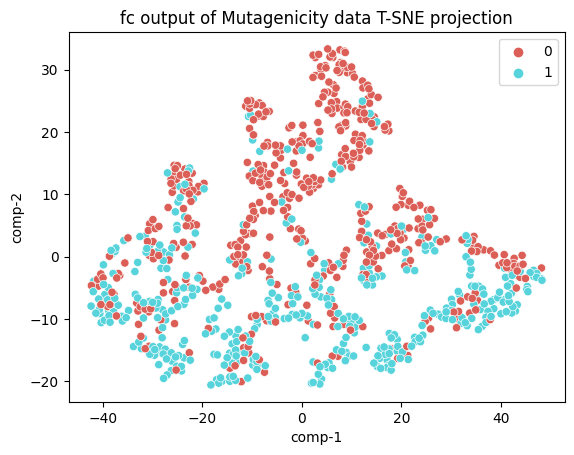

In [ ]:
df = pd.DataFrame()
df["y"] = fc_y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="fc output of Mutagenicity data T-SNE projection")

plt.savefig('GNN_Mutagenicity_fc_tsne.pdf')
files.download('GNN_Mutagenicity_fc_tsne.pdf')